# Feed-forward Artificial Neural Networks


In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import time

## Learning the XOR function


Let us consider the XOR ("exclusive or") function. The [truth table](https://en.wikipedia.org/wiki/Exclusive_or#Truth_table) of the XOR function is:


In [ ]:
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs = np.array([[0], [1], [1], [0]])

We consider a fully connected ANN with the following architechture and with $\tanh(\cdot)$ as activation function:


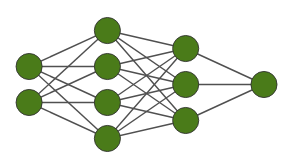


The input of the network are the truth values of the two inputs (0 = False, 1 = True). The output is the **likelihood** (the "probability") of the truth value of the result. Hence, we want the output to be in $[0, 1]$. For this reason, we apply the activation function also to the last layer, and we rescale the output between 0 and 1.

The architecture is defined by the following **hyperparameters**:


In [ ]:
n1, n2, n3, n4 = 2, 4, 3, 1

Define the parameters (weights and biases) of the ANN.
Initialize the weights sampling from a standard normal distribution, and initialize to zero the biases.

Define both the weights and the biases as a 2-dimensional `jax` array (you can define them in `numpy` and then convert them).


In [ ]:
# SOLUTION-BEGIN
np.random.seed(0)  # for reproducibility

W1 = np.random.randn(n2, n1)
b1 = np.zeros((n2, 1))
W2 = np.random.randn(n3, n2)
b2 = np.zeros((n3, 1))
W3 = np.random.randn(n4, n3)
b3 = np.zeros((n4, 1))
params = [W1, b1, W2, b2, W3, b3]
params = [jnp.array(p) for p in params]
# SOLUTION-END

Define a function that implements the ANN:

```python
def ANN(x, params):
  ...
```

with inputs:

- `x`: num_samples by 2 `numpy` array
- `params`: list of the parameters
  and with output
- `y`: num_samples by 1 `numpy` array

Then, test the function on `inputs` and `params`.


In [ ]:
# SOLUTION-BEGIN
def ANN(x, params):
    W1, b1, W2, b2, W3, b3 = params
    layer1 = x.T
    layer2 = jnp.tanh(W1 @ layer1 - b1)
    layer3 = jnp.tanh(W2 @ layer2 - b2)
    layer4 = jnp.tanh(W3 @ layer3 - b3)
    layer4 = (1.0 + layer4) / 2.0
    return layer4.T


ANN(inputs, params)
# SOLUTION-END

Print the truth table associated with the ANN.


In [ ]:
for input in inputs:
  print(f"{input[0]} XOR {input[1]} --> {ANN(input.reshape((1, -1)), params)}")

Define a function that computes the quadratic loss on a set of data:

```python
def loss_quadratic(x, y, params):
  ...
```

with inputs:

- `x`: num_samples by 2 `numpy` array
- `y`: num_samples by 1 `numpy` array
- `params`: list of the parameters
  and with output
- `loss`: scalar

Then, test the function on `inputs`, `outputs` and `params`.


In [ ]:
# SOLUTION-BEGIN
def loss_quadratic(x, y, params):
    error = ANN(x, params) - y
    return jnp.sum(error * error)


loss_quadratic(inputs, outputs, params)
# SOLUTION-END

Define a function that computes the cross-entropy loss on a set of data:

$$-\sum_i y_i \log(y(x_i; \theta)) + (1 - y_i) \log(1 - y(x_i; \theta)) $$

```python
def loss_crossentropy(x, y, params):
  ...
```

with inputs:

- `x`: num_samples by 2 `numpy` array
- `y`: num_samples by 1 `numpy` array
- `params`: list of the parameters
  and with output
- `loss`: scalar

Then, test the function on `inputs`, `outputs` and `params`.


In [ ]:
# SOLUTION-BEGIN
def loss_crossentropy(x, y, params):
    y_app = ANN(x, params)
    return -jnp.sum(y * jnp.log(y_app) + (1 - y) * jnp.log(1 - y_app))


loss_crossentropy(inputs, outputs, params)
# SOLUTION-END

Using the JIT module of JAX, compile both the losses defined above and their gradients w.r.t. the parameters.


In [ ]:
# SOLUTION-BEGIN
loss_quad_jit = jax.jit(loss_quadratic)
grad_quad_jit = jax.jit(jax.grad(loss_quadratic, argnums=2))
loss_Xent_jit = jax.jit(loss_crossentropy)
grad_Xent_jit = jax.jit(jax.grad(loss_crossentropy, argnums=2))
# SOLUTION-END

Implement the GD (gradient descent) method, with learning rate 0.1 and train the ANN, using either the quadratic or the cross-entropy loss function.
Collect the training history of both loss functions at each training epoch and plot them.

Finally, print the truth table associated with the ANN and compute its accuracy.


In [ ]:
grad = grad_quad_jit
#grad = grad_Xent_jit
learning_rate = 1e-1

history_quad = list()
history_Xent = list()

# SOLUTION-BEGIN
t0 = time.time()
for epoch in range(2000):
    grads = grad(inputs, outputs, params)
    for i in range(len(params)):
        params[i] -= learning_rate * grads[i]
    history_quad.append(loss_quad_jit(inputs, outputs, params))
    history_Xent.append(loss_Xent_jit(inputs, outputs, params))

print(f"elapsed time: {time.time() - t0}")
plt.semilogy(history_quad, label="quadratic")
plt.semilogy(history_Xent, label="X-entropy")
plt.legend()
# SOLUTION-END

In [ ]:
for input in inputs:
  print(f"{input[0]} XOR {input[1]} --> {ANN(input.reshape((1, -1)), params)}")

Compute the accuracy of the ANN

In [ ]:
# SOLUTION-BEGIN
TP = ANN(np.array([[0, 1], [1, 0]]), params)
TN = 1 - ANN(np.array([[0, 0], [1, 1]]), params)
accuracy = (sum(TP) + sum(TN)) / 4
print(f"accuracy: {accuracy[0] * 100:1.2f}%")
# SOLUTION-END

### Generalize the process

We test the ANN on a dataset made by a large circle containing a smaller circle in 2d.
This is a simple toy dataset to visualize clustering and classification algorithms.

In [ ]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=300, factor=0.5, noise=0.1)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten())
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(), marker="x")


#### Ingredients

- `init_layer_params(key, in_dim, out_dim)`: given a random key and the in/out shape of a layer, it initializes and return the weighs and biases of the layer
- `init_mlp_params(key, layer_sizes)`: given a random key and a list of layer sizes, it initializes and return the list of weighs and biases pairs of the layer
- `sigmoid(x)`: $1 / (1 + e^{-x})$
- `forward(params, x)`: the evaluation of the neural network with parameters `params` with input `x`
- `binary_cross_entropy(params, x, y)`: cross-entropy loss (as we did before)
- `update(params, x, y, lr)`: given the parameters `params` (list of pairs of weight, bias), update them using (stochastic) gradient descent using data `x` and `y` (assume they are a mini-batch) with learnig rate `lr`


In [ ]:
# SOLUTION-BEGIN
def init_layer_params(W_key, in_dim, out_dim):
    W = jax.random.normal(W_key, (in_dim, out_dim))
    b = jnp.zeros((out_dim,))
    return W, b

def init_mlp_params(key, layer_sizes):
    keys = jax.random.split(key, len(layer_sizes) - 1)
    params = []
    for i in range(len(layer_sizes) - 1):
        params.append(init_layer_params(keys[i], layer_sizes[i], layer_sizes[i + 1]))
    return params

def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def forward(params, x):
    for (W, b) in params[:-1]:
        x = jnp.tanh(x @ W + b)
    W, b = params[-1]
    logits = x @ W + b
    return sigmoid(logits)

def binary_cross_entropy(params, x, y):
    preds = forward(params, x)
    eps = 1e-7
    loss = -jnp.mean(y * jnp.log(preds + eps) + (1 - y) * jnp.log(1 - preds + eps))
    return loss

@jax.jit
def update(params, x, y, lr):
    grads = jax.grad(binary_cross_entropy)(params, x, y)
    new_params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params, grads)
    return new_params
# SOLUTION-END

#### Training
Initialize a neural network with layers `[2, 16, 16, 1]` and train it with SDG

In [ ]:
key = jax.random.PRNGKey(0)
layer_sizes = [2, 16, 16, 1]
params = init_mlp_params(key, layer_sizes)
learning_rate = 0.01
epochs = 5000
batch_size = 64

# SOLUTION-BEGIN
num_batches = X_train.shape[0] // batch_size
for epoch in range(epochs):
    perm_key, key = jax.random.split(key)
    perm = jax.random.permutation(perm_key, X_train.shape[0])
    X_shuffled = X_train[perm]
    y_shuffled = y_train[perm]

    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        xb, yb = X_shuffled[start:end], y_shuffled[start:end]
        params = update(params, xb, yb, learning_rate)

    if epoch % 100 == 0:
        loss = binary_cross_entropy(params, X_train, y_train)
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
# SOLUTION-END


Compute the accuracy and confusion matrix for the predictions of the neural network

In [ ]:
from sklearn.metrics import confusion_matrix

# SOLUTION-BEGIN
y_pred = forward(params, X_test)
acc = jnp.mean((y_pred > 0.5) == y_test)
print(f"Test accuracy: {acc:.3f}")
print(confusion_matrix(y_test, (y_pred > 0.5)))
# SOLUTION-END

Visualize the results

In [ ]:
import numpy as np
# Create a meshgrid over the input space
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                      np.linspace(y_min, y_max, 300))
grid = np.column_stack([xx.ravel(), yy.ravel()])

# Predict over the grid
Z = forward(params, grid)
Z = Z.reshape(xx.shape)

# Plot decision boundary and data points
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.4, cmap='coolwarm')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(), cmap='coolwarm', s=20, edgecolor='k')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(), cmap='coolwarm', s=20, marker="x")
plt.title(f"Decision boundary (accuracy={acc:.3f})")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()